In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Let's first load the daily bike data
bike_df = pd.read_csv('daily_cycling_data_berlin_12032025.csv')

In [3]:
print(bike_df.shape)

(52017, 5)


In [4]:
# Now, let's load the daily motor data
motor_df = pd.read_csv('daily_motor_traffic_berlin_12032025.csv')

In [5]:
print(motor_df.shape)

(1595853, 10)


In [6]:
print("\n Date Range in Bike:", bike_df['date'].min(), "to", bike_df['date'].max())

print("\n Date Range in Motorized Traffic:", motor_df['date'].min(), "to", motor_df['date'].max())


 Date Range in Bike: 2015-01-01 to 2023-12-31

 Date Range in Motorized Traffic: 2015-01-01 to 2023-12-31


In [7]:
print("\n Missing values:\n", bike_df.isnull().sum().sort_values(ascending=False).head(10))


 Missing values:
 station_name      0
date              0
latitude          0
longitude         0
cycling_volume    0
dtype: int64


In [8]:
print("\n Missing values:\n", motor_df.isnull().sum().sort_values(ascending=False).head(10))


 Missing values:
 detid                           0
date                            0
num_motor_vehicles_per_hour     0
avg_speed_motor_vehicles_kmh    0
num_cars_per_hour               0
avg_speed_cars_kmh              0
num_trucks_per_hour             0
avg_speed_trucks_kmh            0
latitude                        0
longitude                       0
dtype: int64


In [4]:
# Now, let's convert timestamps to datetime format for both the datasets
bike_df['date'] = pd.to_datetime(bike_df['date'])
motor_df['date'] = pd.to_datetime(motor_df['date'])

In [5]:
# Now, let's create the GeoDataFrames for the bike data and the motor data
bike_gdf = gpd.GeoDataFrame(
    bike_df,
    geometry=gpd.points_from_xy(bike_df.longitude, bike_df.latitude),
    crs="EPSG:4326"
).to_crs(epsg=25833)

In [6]:
# Now, let's create the GeoDataFrames for the the motor data
# Convert motor data
motor_gdf = gpd.GeoDataFrame(
    motor_df,
    geometry=gpd.points_from_xy(motor_df.longitude, motor_df.latitude),
    crs="EPSG:4326"
).to_crs(epsg=25833)

In [7]:
# Let's precompute the unique dates
unique_dates = bike_gdf['date'].dt.date.unique()

# And create am empty dataframe
results = []

In [8]:
# Now, let's process for each date
for current_date in tqdm(unique_dates):
    # Filter daily bike and motor data
    bike_day = bike_gdf[bike_gdf['date'].dt.date == current_date].copy()
    motor_day = motor_gdf[motor_gdf['date'].dt.date == current_date].copy()

    if motor_day.empty or bike_day.empty:
        continue

    #And, compute city-wide motor features
    city_avg_motor_speed = motor_day['avg_speed_motor_vehicles_kmh'].mean()
    city_avg_car_speed = motor_day['avg_speed_cars_kmh'].mean()
    city_avg_truck_speed = motor_day['avg_speed_trucks_kmh'].mean()
    city_total_motor_vehicles = motor_day['num_motor_vehicles_per_hour'].sum()
    city_total_cars = motor_day['num_cars_per_hour'].sum()
    city_total_trucks = motor_day['num_trucks_per_hour'].sum()

    #Let's loop through each bike counter on that day
    for idx, bike_row in bike_day.iterrows():
        buffer_geom = bike_row.geometry.buffer(6000)
        nearby_motor = motor_day[motor_day.geometry.within(buffer_geom)]

        if nearby_motor.empty:
            continue

        # And, aAggregate nearby motor features
        results.append({
            'date': current_date,
            'station_name': bike_row['station_name'],
            'latitude': bike_row['latitude'],
            'longitude': bike_row['longitude'],
            'cycling_volume': bike_row['cycling_volume'],

            # Local (6km radius) features
            'avg_motor_volume': nearby_motor['num_motor_vehicles_per_hour'].mean(),
            'avg_motor_speed': nearby_motor['avg_speed_motor_vehicles_kmh'].mean(),
            'avg_car_speed': nearby_motor['avg_speed_cars_kmh'].mean(),
            'avg_truck_speed': nearby_motor['avg_speed_trucks_kmh'].mean(),
            'total_motor_cars': nearby_motor['num_cars_per_hour'].sum(),
            'total_motor_trucks': nearby_motor['num_trucks_per_hour'].sum(),
            'num_motor_sources': len(nearby_motor),

            # City-wide features
            'city_avg_motor_speed': city_avg_motor_speed,
            'city_avg_car_speed': city_avg_car_speed,
            'city_avg_truck_speed': city_avg_truck_speed,
            'city_total_motor_vehicles': city_total_motor_vehicles,
            'city_total_cars': city_total_cars,
            'city_total_trucks': city_total_trucks
        })

100%|████████████████████████████████████████████████████████████████████████████| 3287/3287 [1:08:26<00:00,  1.25s/it]


In [9]:
# And finally merge and save the dataset
final_df = pd.DataFrame(results)
final_df.to_csv('bike_with_motor_traffic_18032025.csv', index=False)

print("Full merged data saved as 'bike_with_motor_traffic_18032025.csv'")

Full merged data saved as 'bike_with_motor_traffic_18032025.csv'


In [10]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51679 entries, 0 to 51678
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       51679 non-null  object 
 1   station_name               51679 non-null  object 
 2   latitude                   51679 non-null  float64
 3   longitude                  51679 non-null  float64
 4   cycling_volume             51679 non-null  float64
 5   avg_motor_volume           51679 non-null  float64
 6   avg_motor_speed            51679 non-null  float64
 7   avg_car_speed              51679 non-null  float64
 8   avg_truck_speed            51679 non-null  float64
 9   total_motor_cars           51679 non-null  int64  
 10  total_motor_trucks         51679 non-null  int64  
 11  num_motor_sources          51679 non-null  int64  
 12  city_avg_motor_speed       51679 non-null  float64
 13  city_avg_car_speed         51679 non-null  flo

<Axes: title={'center': 'Total Cycling Volume Over Time'}, xlabel='date'>

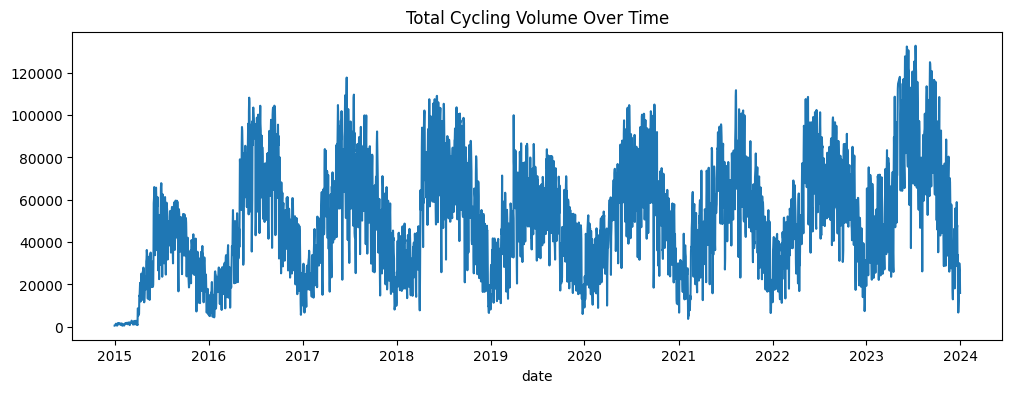

In [11]:
final_df.groupby('date')['cycling_volume'].sum().plot(figsize=(12, 4), title="Total Cycling Volume Over Time")

## Summary

This script processes and merges two large-scale datasets from Berlin: daily bicycle counts and daily motorized traffic counts from 2015 to 2023. It begins by loading the datasets and converting them into GeoDataFrames using geographic coordinates (latitude and longitude). The bike data contains daily cycling volumes recorded at specific stations (station_name) with associated coordinates, while the motorized traffic dataset includes daily measurements of vehicle volume and speed, broken down by vehicle types (num_motor_vehicles_per_hour, num_cars_per_hour, num_trucks_per_hour) and their respective average speeds (avg_speed_motor_vehicles_kmh, avg_speed_cars_kmh, avg_speed_trucks_kmh). Once loaded, the script parses the date fields and ensures all spatial data is projected using the EPSG:25833 coordinate reference system for accurate distance-based operations.

For each unique date in the dataset, the script computes two sets of traffic features. First, it calculates city-wide aggregates across all motorized traffic counting stations, including total volumes (city_total_motor_vehicles, city_total_cars, city_total_trucks) and average speeds (city_avg_motor_speed, city_avg_car_speed, city_avg_truck_speed). Second, for each bicycle counting station on that date, it creates a 6-kilometer buffer around the station and identifies all motorized traffic stations within that radius. Using only these nearby stations, the script computes localized features: average volume (avg_motor_volume), average speeds (avg_motor_speed, avg_car_speed, avg_truck_speed), and total vehicle counts (total_motor_cars, total_motor_trucks). It also tracks the number of contributing stations with num_motor_sources. All these features are compiled into a final dataset that links bicycle volumes with both local and city-wide motor traffic conditions on a daily level, and saved as bike_with_motor_traffic_18032025.csv.